In [77]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.utils import img_to_array, array_to_img, load_img
from keras import metrics
import matplotlib.pyplot as plt
from sklearn import metrics

mids_dir = Path("D:\\MIDS-W207")
data = mids_dir/"datasets/soccertrack_square"
project = mids_dir/"MIDS-W207-Spring24-Soccer-Detection"
analysis = project/"analysis"

# Author: Timothy Majidzadeh
# Date Created: April 6, 2024
# Date Updated: April 16, 2024
# Description: Try logistic regression on the soccertrack_square dataset.
# Adapts some code from T. Majidzadeh's Homework 4, 5, 7 and 10 submissions for MIDS W207 Spring 2024.
# Notes: [v1] Created program. 
# Inputs: Frame-by-frame labels saved as separate text files.
# Outputs: Logistic regression classifiers.

In [13]:
# 1. Load the labels data and map to classes.
class_dict = {
    0: "No Objects",
    1: "Team 0 Only",
    2: "Team 1 Only",
    3: "Ball Only",
    4: "Team 0 and Team 1",
    5: "Team 0 and Ball",
    6: "Team 1 and Ball",
    7: "All Classes"
}

# Because certain class combinations are rare, it may be more effective to try each class individually.
# Remap to a value of 1 if one class is present, 0 otherwise.
ball_remap = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 0,
    5: 1,
    6: 1,
    7: 1
}

team_0_remap = {
    0: 0,
    1: 1,
    2: 0,
    3: 0,
    4: 1,
    5: 1,
    6: 0,
    7: 1
}

team_1_remap = {
    0: 0,
    1: 0,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 1,
    7: 1
}
objects_per_image = pd.read_pickle(data/"objects_per_image_oversampled.pkl")

In [3]:
def class_mapping(ball_count, team_0_count, team_1_count):
    '''
    Assigns each row in the objects_per_image DataFrame to a class based on object counts.
    '''
    if (ball_count == 0) & (team_0_count == 0) & (team_1_count == 0):
        return 0
    elif (ball_count == 0) & (team_0_count > 0) & (team_1_count == 0):
        return 1
    elif (ball_count == 0) & (team_0_count == 0) & (team_1_count > 0):
        return 2
    elif (ball_count > 0) & (team_0_count == 0) & (team_1_count == 0):
        return 3
    elif (ball_count == 0) & (team_0_count > 0) & (team_1_count > 0):
        return 4
    elif (ball_count > 0) & (team_0_count > 0) & (team_1_count == 0):
        return 5
    elif (ball_count > 0) & (team_0_count == 0) & (team_1_count > 0):
        return 6
    else:
        return 7

In [18]:
objects_per_image['class'] = objects_per_image[
    ['img_ball_count', 'img_team_0_count', 'img_team_1_count']
].apply(lambda x: class_mapping(x.img_ball_count, x.img_team_0_count, x.img_team_1_count), axis=1)

objects_per_image['multiclass'] = objects_per_image['class']
objects_per_image['ball_binary'] = objects_per_image['class'].replace(ball_remap)
objects_per_image['team_0_binary'] = objects_per_image['class'].replace(team_0_remap)
objects_per_image['team_1_binary'] = objects_per_image['class'].replace(team_1_remap)

objects_per_image

class,image_name,img_ball_count,img_team_0_count,img_team_1_count,class,multiclass,ball_binary,team_0_binary,team_1_binary
23905,top_view_31511.png,1,4,4,7,7,1,1,1
17885,top_view_26094.png,1,2,2,7,7,1,1,1
84829,wide_view_38446.png,1,5,2,7,7,1,1,1
57622,wide_view_1396.png,1,9,9,7,7,1,1,1
88127,wide_view_41413.png,0,0,1,2,2,0,0,1
...,...,...,...,...,...,...,...,...,...
57678,wide_view_14009.png,0,0,0,0,0,0,0,0
1884,top_view_11693.png,0,0,0,0,0,0,0,0
15097,top_view_23585.png,1,4,6,7,7,1,1,1
99593,wide_view_9144.png,1,6,3,7,7,1,1,1


C:\Users\timot\anaconda3\envs\tf_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='class', ylabel='Count'>

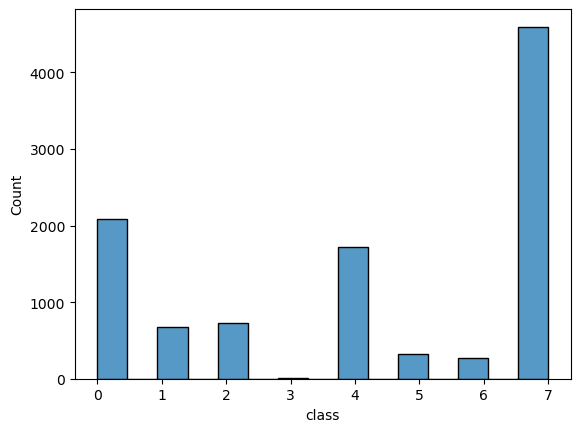

In [6]:
sns.histplot(objects_per_image['class'])

In [7]:
# Adapted T. Majidzadeh's HW 10 submission, with some edits for the use case.

def load_data(image_paths, labels, splits):
    """ Load and split data into train, validation and test sets
    
    Params:
    -------
    image_paths (np.ndarray): Paths to load images.
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 100, 100)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 100, 100)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 100, 100)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """

    # Data is already shuffled on input.
    # create data splits (training, val, and test sets)
    train_val_index = int(np.floor(len(labels) * splits[0]))
    val_test_index = int(np.floor(len(labels) * (splits[0] + splits[1])))

    X_train_paths, y_train = image_paths[0:train_val_index], labels[0:train_val_index]
    X_val_paths, y_val = image_paths[train_val_index:val_test_index], labels[train_val_index:val_test_index]
    X_test_paths, y_test = image_paths[val_test_index:], labels[val_test_index:]

    print("Loading train...")
    X_train = [img_to_array(load_img(path, color_mode='grayscale', target_size=(100,100))) for path in X_train_paths]
    print("Loading val...")
    X_val = [img_to_array(load_img(path, color_mode='grayscale', target_size=(100,100))) for path in X_val_paths]
    print("Loading test...")
    X_test = [img_to_array(load_img(path, color_mode='grayscale', target_size=(100,100))) for path in X_test_paths]
    return X_train, y_train, X_val, y_val, X_test, y_test

def preprocess_data(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Applies augmentations
    
    Params:
    -------
    X_train (np.ndarray): Train images of shape (N_train, 100, 100)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 100, 100)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 100, 100)
    y_test (np.ndarray): Test labels of shape (N_test,)

    Returns:
    --------
    Augmented & Rescaled Values for X_train
    """
    # image augmentation (random flip) on training data
    print("Augmenting: Left-right flip")
    X_train = tf.image.flip_left_right(X_train)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    print("Shuffling...")
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0 
    print("Rescaling and Squeezing...")
    X_train, X_val, X_test = np.squeeze(np.array(X_train)), np.squeeze(np.array(X_val)), np.squeeze(np.array(X_test))
    X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255

    print("Done!")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# 2. Load the images and match to labels. Format as NumPy arrays.
paths = np.array([data/"images"/name for name in objects_per_image['image_name']])
labels = np.array(objects_per_image['multiclass'])
splits = (0.8, 0.1, 0.1)
X_train, multiclass_train, X_val, multiclass_val, X_test, multiclass_test = load_data(paths, labels, splits)
X_train, multiclass_train, X_val, multiclass_val, X_test, multiclass_test = preprocess_data(X_train, multiclass_train, X_val, multiclass_val, X_test, multiclass_test)

Loading train...
Loading val...
Loading test...
Augmenting: Left-right flip
Shuffling...
Rescaling and Squeezing...
Done!


In [33]:
ball_binary_train, ball_binary_val, ball_binary_test = np.vectorize(ball_remap.get)(multiclass_train), np.vectorize(ball_remap.get)(multiclass_val), np.vectorize(ball_remap.get)(multiclass_test)

In [35]:
team_0_binary_train, team_0_binary_val, team_0_binary_test = np.vectorize(team_0_remap.get)(multiclass_train), np.vectorize(team_0_remap.get)(multiclass_val), np.vectorize(team_0_remap.get)(multiclass_test)

In [36]:
team_1_binary_train, team_1_binary_val, team_1_binary_test = np.vectorize(team_1_remap.get)(multiclass_train), np.vectorize(team_1_remap.get)(multiclass_val), np.vectorize(team_1_remap.get)(multiclass_test)

In [63]:
# Define loss & model functions.
# Re-used from T. Majidzadeh's HW 5 submission.
# We re-formatted the data above so that it can work with this model.
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      # YOUR CODE HERE
      units=n_classes,
      activation="softmax"
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  # YOUR CODE HERE
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

In [65]:
# Multiclass predictor
multiclass_model = build_model(len(objects_per_image['class'].unique()))
multiclass_model.fit(
    x = X_train,
    y = multiclass_train,
    epochs = 20,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2975 - loss: 4.7779 - val_accuracy: 0.4688 - val_loss: 4.1330
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3160 - loss: 4.7615 - val_accuracy: 0.1130 - val_loss: 3.9004
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3219 - loss: 4.2736 - val_accuracy: 0.2163 - val_loss: 3.3347
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3345 - loss: 4.1533 - val_accuracy: 0.2151 - val_loss: 3.8321
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3440 - loss: 3.9534 - val_accuracy: 0.2019 - val_loss: 4.9696
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3442 - loss: 3.9806 - val_accuracy: 0.1058 - val_loss: 4.3896
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3389 - loss: 4.0922 - val_accuracy: 0.1947 - val_loss: 5.0079
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3494 - loss: 3.7404 - val_accuracy: 0.

In [40]:
def plot_confusion_matrix(labels, predictions, names):
    '''
    Plot a confusion matrix given a set of labels, names, and predictions.
    '''
    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(labels, predictions)
    
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, fmt='.3g', cmap='Blues',
                     xticklabels=names, yticklabels=names, cbar=False)
    
    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
[4 4 4 ... 4 4 1]


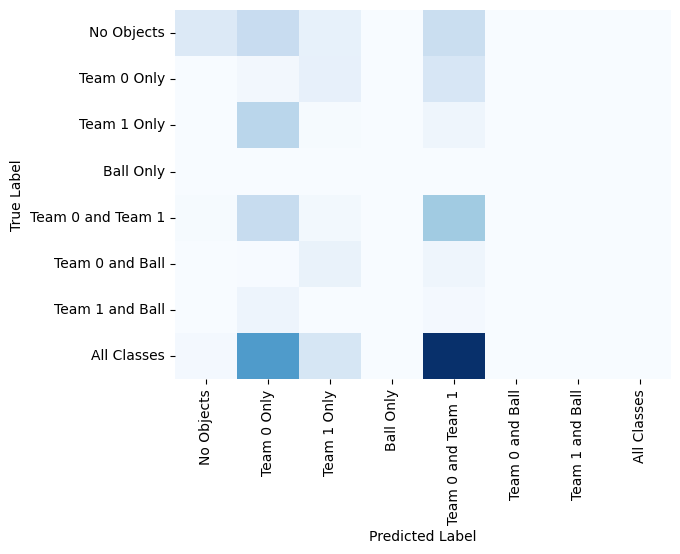

In [41]:
multiclass_predictions = np.argmax(multiclass_model.predict(X_test), axis=-1)
print(multiclass_predictions)
plot_confusion_matrix(multiclass_test, multiclass_predictions, class_dict.values())

In [80]:
print("Precision: ", metrics.precision_score(multiclass_test, multiclass_predictions, average='weighted'))
print("Recall: ", metrics.recall_score(multiclass_test, multiclass_predictions, average='weighted'))

Precision:  0.393264896698275
Recall:  0.13846153846153847


C:\Users\timot\anaconda3\envs\tf_env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# Ball presence predictor
ball_binary_model = build_model(2)
ball_binary_model.fit(
    x = X_train,
    y = ball_binary_train,
    epochs = 20,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4931 - loss: 4.7051 - val_accuracy: 0.5337 - val_loss: 1.3185
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5156 - loss: 4.3169 - val_accuracy: 0.5288 - val_loss: 6.4680
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4860 - loss: 5.0153 - val_accuracy: 0.5288 - val_loss: 6.3907
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4885 - loss: 4.9635 - val_accuracy: 0.5288 - val_loss: 6.3209
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4898 - loss: 4.9123 - val_accuracy: 0.5288 - val_loss: 6.3596
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4924 - loss: 4.8663 - val_accuracy: 0.5288 - val_loss: 6.3052
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4941 - loss: 4.8236 - val_accuracy: 0.5300 - val_loss: 6.2499
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4954 - loss: 4.7865 - val_accuracy: 0.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[1 1 0 ... 0 0 1]


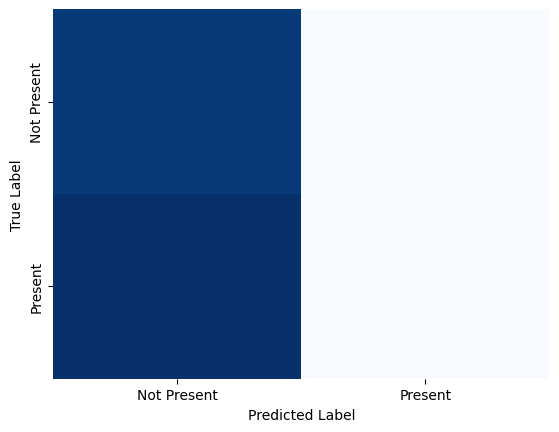

In [43]:
ball_binary_predictions = np.argmax(ball_binary_model.predict(X_test), axis=-1)
print(ball_binary_predictions)
plot_confusion_matrix(ball_binary_test, ball_binary_predictions, ["Not Present", "Present"])

In [49]:
# 50% accuracy is not so great when that's the baseline prevalance in the dataset!
objects_per_image.query('img_ball_count > 0').shape

(5200, 9)

In [83]:
print("Precision: ", metrics.precision_score(ball_binary_test, ball_binary_predictions, average='binary'))
print("Recall: ", metrics.recall_score(ball_binary_test, ball_binary_predictions, average='binary'))

Precision:  0.5
Recall:  0.17870722433460076


In [45]:
# Team 0 presence predictor
team_0_binary_model = build_model(2)
team_0_binary_model.fit(
    x = X_train,
    y = team_1_binary_train,
    epochs = 20,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5801 - loss: 3.3539 - val_accuracy: 0.7067 - val_loss: 3.1602
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6081 - loss: 3.0250 - val_accuracy: 0.7067 - val_loss: 2.5537
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6226 - loss: 2.5287 - val_accuracy: 0.7067 - val_loss: 6.4807
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6359 - loss: 2.8164 - val_accuracy: 0.7296 - val_loss: 0.6101
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6352 - loss: 2.3775 - val_accuracy: 0.7067 - val_loss: 4.6311
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6371 - loss: 2.5463 - val_accuracy: 0.7067 - val_loss: 4.0833
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6515 - loss: 2.3137 - val_accuracy: 0.7103 - val_loss: 3.2270
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6361 - loss: 2.4051 - val_accuracy: 0.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[1 1 1 ... 0 1 1]


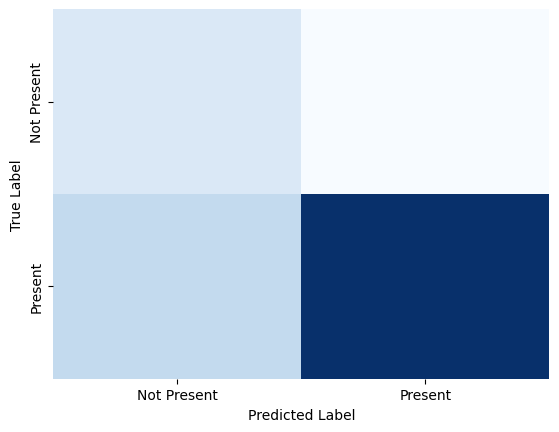

In [47]:
team_0_binary_predictions = np.argmax(team_0_binary_model.predict(X_test), axis=-1)
print(team_0_binary_predictions)
plot_confusion_matrix(team_0_binary_test, team_0_binary_predictions, ["Not Present", "Present"])

In [50]:
objects_per_image.query('img_team_0_count > 0').shape

(7310, 9)

In [84]:
print("Precision: ", metrics.precision_score(team_0_binary_test, team_0_binary_predictions, average='binary'))
print("Recall: ", metrics.recall_score(team_0_binary_test, team_0_binary_predictions, average='binary'))

Precision:  0.815625
Recall:  0.7006711409395974


In [52]:
# Team 1 presence predictor
team_1_binary_model = build_model(2)
team_1_binary_model.fit(
    x = X_train,
    y = team_1_binary_train,
    epochs = 20,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5913 - loss: 3.2879 - val_accuracy: 0.7067 - val_loss: 1.8663
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6051 - loss: 2.9254 - val_accuracy: 0.7067 - val_loss: 2.5288
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6278 - loss: 2.6280 - val_accuracy: 0.7067 - val_loss: 5.8960
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6292 - loss: 2.7106 - val_accuracy: 0.7296 - val_loss: 0.6100
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6490 - loss: 2.1231 - val_accuracy: 0.6334 - val_loss: 0.8353
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6505 - loss: 2.2801 - val_accuracy: 0.6659 - val_loss: 0.8038
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6446 - loss: 2.3457 - val_accuracy: 0.6887 - val_loss: 0.7486
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6406 - loss: 2.2291 - val_accuracy: 0.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[1 1 1 ... 1 1 1]


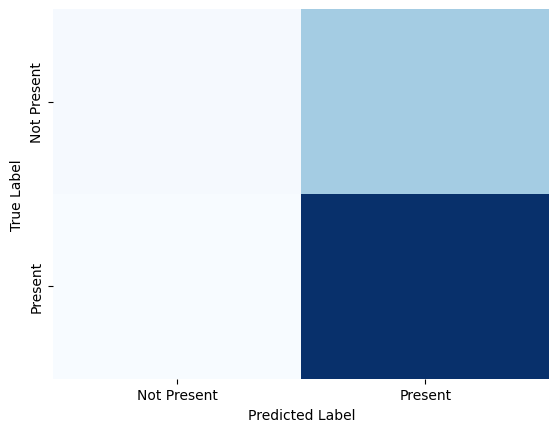

In [53]:
team_1_binary_predictions = np.argmax(team_1_binary_model.predict(X_test), axis=-1)
print(team_1_binary_predictions)
plot_confusion_matrix(team_1_binary_test, team_1_binary_predictions, ["Not Present", "Present"])

In [87]:
objects_per_image.query('img_team_1_count > 0').shape

(7313, 9)

In [85]:
print("Precision: ", metrics.precision_score(team_1_binary_test, team_1_binary_predictions, average='binary'))
print("Recall: ", metrics.recall_score(team_1_binary_test, team_1_binary_predictions, average='binary'))

Precision:  0.7327416173570019
Recall:  0.9893475366178429
